In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import roc_curve
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import sqlite3
import pickle


In [3]:
df = pd.read_csv('data/Billboard_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              5760 non-null   object 
 1   title             5760 non-null   object 
 2   artist            5760 non-null   object 
 3   weeks             5760 non-null   int64  
 4   rank              5760 non-null   int64  
 5   change            5760 non-null   object 
 6   broad_genre       5760 non-null   object 
 7   energy            5760 non-null   float64
 8   liveness          5760 non-null   float64
 9   tempo             5760 non-null   float64
 10  speechiness       5760 non-null   float64
 11  acousticness      5760 non-null   float64
 12  instrumentalness  5760 non-null   float64
 13  time_signature    5760 non-null   object 
 14  danceability      5760 non-null   float64
 15  key               5760 non-null   float64
 16  duration_ms       5760 non-null   object 


In [4]:
rap_rb = df[(df['broad_genre'] == 'rap') | (df['broad_genre'] == 'r&b')].copy().reset_index(drop=True)
rap_rb


,date,title,artist,weeks,rank,change,broad_genre,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,12/31/17,1-800-273-8255,logic,35,34,0,rap,0.572,0.1920,100.015,...,0.57000,0.000000,4,0.629,5.0,250173,-7.733,0.3860,0.0,I've been on the low\nI been taking my time\nI...
1,12/31/17,All I Want For Christmas Is You,mariah carey,24,13,-4,r&b,0.625,0.0708,150.277,...,0.16400,0.000000,4,0.335,7.0,241107,-7.462,0.3460,1.0,I don't want a lot for Christmas\nThere is jus...
2,12/31/17,Bank Account,21 savage,25,28,7,rap,0.346,0.0871,75.016,...,0.01510,0.000007,4,0.884,8.0,220307,-8.228,0.3760,0.0,I buy a new car for the bitch (for real)\nI te...
3,12/31/17,Betrayed,lil xan,7,75,2,rap,0.419,0.1050,119.958,...,0.41600,0.000000,4,0.823,10.0,187453,-10.358,0.2770,0.0,Pop the trunk I open up I sold my soul for a g...
4,12/31/17,Black & Chinese,huncho jack,1,71,New,rap,0.842,0.1230,159.132,...,0.00277,0.000974,4,0.663,1.0,172017,-4.152,0.3460,1.0,What's the problem? What's the problem?\nIn th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,1/22/00,We Can't Be Friends,deborah cox,20,97,-17,r&b,0.436,0.1190,119.910,...,0.04090,0.000000,4,0.556,7.0,281200,-7.906,0.0799,1.0,To just act like we never were\nTo come around...
2687,1/22/00,Will 2K,will smith,13,100,-43,rap,0.783,0.6280,117.934,...,0.06920,0.000000,4,0.827,9.0,233907,-3.918,0.8320,0.0,INSTRUMENTAL
2688,1/15/00,Give You What You Want (Fa Sure),chico debarge,13,94,-7,r&b,0.714,0.0903,132.000,...,0.01180,0.000000,4,0.854,10.0,280067,-7.342,0.7820,0.0,"Gonna get it, get it, get it, get it\nBaby, ba..."
2689,1/8/00,Left & Right,d'angelo,5,91,-21,r&b,0.405,0.3830,92.115,...,0.23500,0.000000,4,0.838,1.0,286467,-9.684,0.8430,1.0,"Yo, yo\nMy flows remarkable\n\nDoc walk like K..."


In [5]:
wordnet = WordNetLemmatizer()
words = stopwords.words("english")
rap_rb['cleaned'] = rap_rb['lyrics'].apply(lambda x: " ".join([wordnet.lemmatize(i) for i in re.sub("[^a-zA-Z^\n\d+\s^\s+|\s+?$]", " ", x).split() if i not in words]).lower())

In [6]:
#first we split our dataset into testing and training set:
# this block is to split the dataset into training and testing set 
X = rap_rb['cleaned']
y = rap_rb['broad_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
vec = TfidfVectorizer(min_df= 2, stop_words="english", sublinear_tf=True, norm='l2',ngram_range=(1, 2))
vec_ft = vec.fit_transform(X_train)
vec_ft.shape

(2152, 46594)

In [8]:
vec_ft.todense

<bound method spmatrix.todense of <2152x46594 sparse matrix of type '<class 'numpy.float64'>'
	with 358305 stored elements in Compressed Sparse Row format>>

In [9]:
rf = RandomForestClassifier(n_estimators=300)

In [10]:
rf.fit(vec_ft,y_train)

RandomForestClassifier(n_estimators=300)

In [11]:
vec_ft_test = vec.transform(X_test)
vec_ft_test.shape

(539, 46594)

In [12]:
rf.score(vec_ft_test,y_test)

0.7922077922077922

              precision    recall  f1-score   support

         r&b       0.77      0.76      0.76       241
         rap       0.81      0.82      0.81       298

    accuracy                           0.79       539
   macro avg       0.79      0.79      0.79       539
weighted avg       0.79      0.79      0.79       539

[[182  59]
 [ 53 245]]


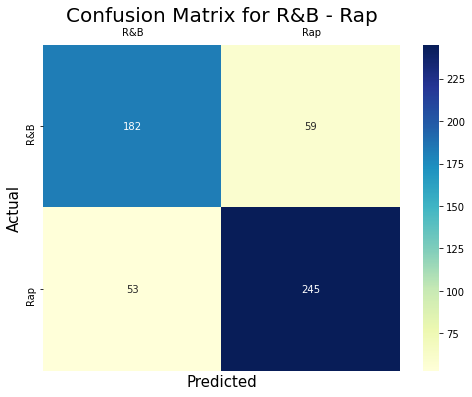

In [50]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(y_test, rf.predict(vec_ft_test)))
print(confusion_matrix(y_test, rf.predict(vec_ft_test)))
categories=['R&B','Rap']
fig, ax = plt.subplots(figsize=(8,6))    
sns.heatmap(confusion_matrix(y_test, rf.predict(vec_ft_test)), annot=True, fmt='g', xticklabels=categories, yticklabels=categories, ax=ax,cmap="YlGnBu")
ax.set_title('Confusion Matrix for R&B - Rap', fontsize=20)
ax.set_xlabel('Predicted',fontsize=15)
ax.set_ylabel('Actual',fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
#plt.savefig('rap_r&_heatmap.png')

In [52]:
feat_names = vec.get_feature_names() 
feat_names = np.array(feat_names)
importance = rf.feature_importances_
importance
indices = np.argsort(importance)[-10:]
feat_names[np.argsort(importance)][-10:]

array(['hoe', 'cause', 'oh', 'girl', 'shit', 'nigga', 'love', 'baby',
       'fuck', 'bitch'], dtype='<U29')

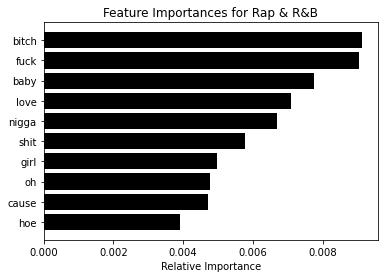

In [53]:
rr = ['hoe', 'cause', 'oh', 'girl', 'shit', 'nigga', 'love', 'baby',
       'fuck', 'bitch']

plt.title('Feature Importances for Rap & R&B')
plt.barh(range(len(indices)), importance[indices], color='black', align='center')
plt.yticks(range(len(indices)),rr )
plt.xlabel('Relative Importance')
#plt.savefig('rap_r&b_feature_imp.png')
plt.show()

## Pop&Country

In [16]:
pop_country = df[(df['broad_genre'] == 'pop') | (df['broad_genre'] == 'country')].copy().reset_index(drop=True)
pop_country['broad_genre'].value_counts()

country    1096
pop        1070
Name: broad_genre, dtype: int64

In [17]:
wordnet = WordNetLemmatizer()
words = stopwords.words("english")
pop_country['cleaned'] = pop_country['lyrics'].apply(lambda x: " ".join([wordnet.lemmatize(i) for i in re.sub("[^a-zA-Z^\n\d+\s^\s+|\s+?$]", " ", x).split() if i not in words]).lower())

In [18]:
#first we split our dataset into testing and training set:
# this block is to split the dataset into training and testing set 
X1 = pop_country['cleaned']
y1 = pop_country['broad_genre']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [19]:
vec1 = TfidfVectorizer(min_df= 2, stop_words="english", sublinear_tf=True, norm='l2',ngram_range=(1, 2))
vec_ft1 = vec1.fit_transform(X1_train)
vec_ft1.shape

(1732, 20056)

In [20]:
vec_ft1.todense
vec_ft_test1 = vec1.transform(X1_test)
vec_ft_test1.shape

(434, 20056)

In [21]:
rf1 = RandomForestClassifier(n_estimators=300)

In [22]:
rf1.fit(vec_ft1,y1_train)

RandomForestClassifier(n_estimators=300)

In [23]:
rf1.score(vec_ft_test1,y1_test)

0.7880184331797235

              precision    recall  f1-score   support

     country       0.76      0.83      0.80       215
         pop       0.82      0.74      0.78       219

    accuracy                           0.79       434
   macro avg       0.79      0.79      0.79       434
weighted avg       0.79      0.79      0.79       434

[[179  36]
 [ 56 163]]


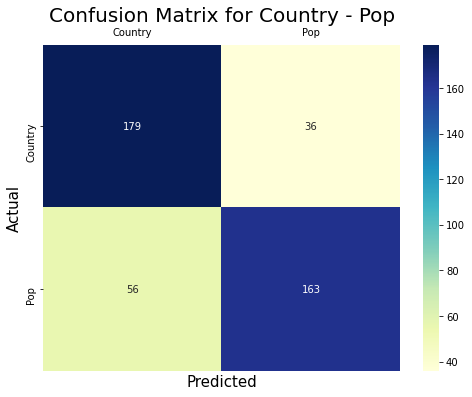

In [54]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(y1_test, rf1.predict(vec_ft_test1)))
print(confusion_matrix(y1_test, rf1.predict(vec_ft_test1)))
categories=['Country','Pop']
fig, ax = plt.subplots(figsize=(8,6))    
sns.heatmap(confusion_matrix(y1_test, rf1.predict(vec_ft_test1)), annot=True, fmt='g', xticklabels=categories, yticklabels=categories, ax=ax,cmap="YlGnBu")
ax.set_title('Confusion Matrix for Country - Pop', fontsize=20)
ax.set_xlabel('Predicted',fontsize=15)
ax.set_ylabel('Actual',fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
#plt.savefig('country_pop_heatmap.png')

In [43]:
feat_names1 = vec1.get_feature_names() 
feat_names1 = np.array(feat_names1)
importance1 = rf1.feature_importances_
importance1
indices = np.argsort(importance1)[-10:]
feat_names1[np.argsort(importance1)][-10:]

array(['good', 'road', 'country', 'oh', 'long', 'truck', 'town', 'man',
       'old', 'little'], dtype='<U29')

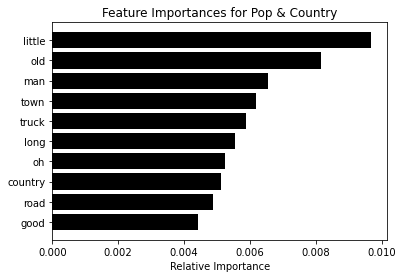

In [44]:
pc = ['good', 'road', 'country', 'oh', 'long', 'truck', 'town', 'man',
       'old', 'little']

plt.title('Feature Importances for Pop & Country')
plt.barh(range(len(indices)), importance1[indices], color='black', align='center')
plt.yticks(range(len(indices)),pc )
plt.xlabel('Relative Importance')
#plt.savefig('pc_feature_imp.png')
plt.show()

## Rock&Pop

In [27]:
pop_rock = df[(df['broad_genre'] == 'pop') | (df['broad_genre'] == 'rock')].copy().reset_index(drop=True)
pop_rock['broad_genre'].value_counts()

pop     1070
rock     692
Name: broad_genre, dtype: int64

In [28]:
wordnet = WordNetLemmatizer()
words = stopwords.words("english")
pop_rock['cleaned'] = pop_rock['lyrics'].apply(lambda x: " ".join([wordnet.lemmatize(i) for i in re.sub("[^a-zA-Z^\n\d+\s^\s+|\s+?$]", " ", x).split() if i not in words]).lower())

In [29]:
X2 = pop_rock['cleaned']
y2 = pop_rock['broad_genre']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=10)

In [30]:
vec2 = TfidfVectorizer(min_df= 2, stop_words="english", sublinear_tf=True, norm='l2',ngram_range=(1, 2))
vec_ft2 = vec2.fit_transform(X2_train)
vec_ft2.shape

(1409, 16153)

In [31]:
vec_ft2.todense
vec_ft_test2 = vec2.transform(X2_test)
vec_ft_test2.shape

(353, 16153)

In [32]:
rf2 = RandomForestClassifier(n_estimators=300)

In [33]:
rf2.fit(vec_ft2,y2_train)

RandomForestClassifier(n_estimators=300)

In [34]:
rf2.predict(vec_ft_test2)

array(['pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'rock', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'rock', 'pop', 'rock', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
       'pop', 'rock', 'rock', 'rock', 'rock', 'pop', 'rock', 'pop', 'pop',
       'pop', 'rock', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
       'rock', 'pop', 'pop', 'pop', 'rock', 'pop', 'pop', 'pop', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
       'rock', 'pop', 'pop', 'pop', 'rock', 'pop', 'pop', 'pop', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'rock', 'pop',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'rock',
       'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop',
     

In [35]:
rf2.score(vec_ft_test2,y2_test)

0.7025495750708215

              precision    recall  f1-score   support

         pop       0.69      0.95      0.80       220
        rock       0.77      0.30      0.43       133

    accuracy                           0.70       353
   macro avg       0.73      0.62      0.62       353
weighted avg       0.72      0.70      0.66       353

[[208  12]
 [ 93  40]]


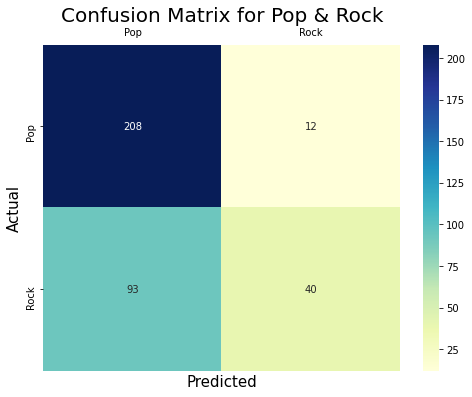

In [55]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(y2_test, rf2.predict(vec_ft_test2)))
print(confusion_matrix(y2_test, rf2.predict(vec_ft_test2)))
categories=['Pop','Rock']
fig, ax = plt.subplots(figsize=(8,6))    
sns.heatmap(confusion_matrix(y2_test, rf2.predict(vec_ft_test2)), annot=True, fmt='g', xticklabels=categories, yticklabels=categories, ax=ax,cmap="YlGnBu")
ax.set_title('Confusion Matrix for Pop & Rock', fontsize=20)
ax.set_xlabel('Predicted',fontsize=15)
ax.set_ylabel('Actual',fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
#plt.savefig('pop_rock_heatmap.png')

In [37]:
feat_names2 = vec2.get_feature_names() 
feat_names2 = np.array(feat_names2)

In [47]:
importance2 = rf2.feature_importances_
importance2
indices = np.argsort(importance2)[-10:]
feat_names1[np.argsort(importance2)][-10:]

array(['start holding', 'knew love', 'hand little', 'breathin',
       'little blue', 'saying run', 'sea fishin', 'homecoming',
       'spinnin like', 'away need'], dtype='<U29')

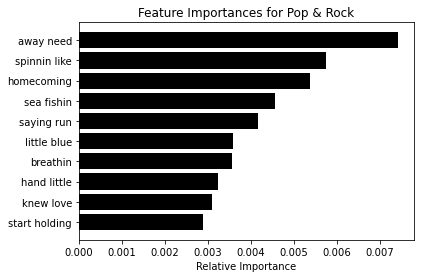

In [48]:
pop_rock = ['start holding', 'knew love', 'hand little', 'breathin',
       'little blue', 'saying run', 'sea fishin', 'homecoming',
       'spinnin like', 'away need']

plt.title('Feature Importances for Pop & Rock')
plt.barh(range(len(indices)), importance2[indices], color='black', align='center')
plt.yticks(range(len(indices)),pop_rock )
plt.xlabel('Relative Importance')
#plt.savefig('pop_rock_feature_imp.png')
plt.show()